# OscoNet: Inferring oscillatory gene networks

This notebook provides an introduction to the bootstrap hypothesis test described in more detaild in the [paper](https://www.biorxiv.org/content/10.1101/600049v1).


In [1]:
%matplotlib inline
from OscopeBootstrap import qvalue
from OscopeBootstrap.create_edge_network_represention import create_edge_network_representation
from OscopeBootstrap.SyntheticDataset import GetSimISyntheticData, true_adj_matrix
from OscopeBootstrap.oscope_tf import bootstrap_hypothesis_test, get_accuracy, get_metrics_for_different_qvalue_thresholds
from matplotlib import pyplot as plt
import numpy as np

### First create a synthetic dataset containing one group of co-oscillating genes

In [2]:
NG = 10  # half gene cluster size so we have a total of 10 co-oscillating genes  
G = 80  # number of genes
N = 1000 # cells
ngroups = 2 # one cluster
data_df, phaseG, angularSpeed = GetSimISyntheticData(NG=NG, G=G, ngroups=ngroups, N=N, noiseLevel=0)
adjacency_matrix_true = true_adj_matrix(G, angularSpeed)  # True adjacency matrix

I am in group 2
NG = 10
White noise from 40


In [3]:
ppp=data_df.iloc


In [4]:
NG


10

### Show an example of each type of gene expression in the synthetic data
1. Strong oscillator which has little noise
1. Weak oscillator with higher noise
1. White noise gene (no oscillation)
For more information on how these are generate see the docstring for `GetSimISyntheticData` and the supplementary material
of the original [Oscope paper](https://www.nature.com/articles/nmeth.3549).

Text(0.5, 1.0, 'white noise gene')

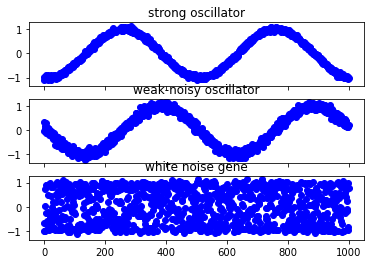

In [5]:
_, ax = plt.subplots(3, sharex=True, sharey=True)
ax[0].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator')
ax[1].plot(np.arange(N), data_df.iloc[NG, :], 'bo'); ax[1].set_title('weak-noisy oscillator')
ax[2].plot(np.arange(N), data_df.iloc[2*NG, :], 'bo'); ax[2].set_title('white noise gene')

### Apply the hypothesis test
This can take 30seconds - 1 minute depending on your hardware.

In [7]:
n_bootstrap = 100  # number of bootstrap samples
grid_points_in_search = 10  # grid size for phase shift parameter estimation., 
alpha = 0.001  # significance level
adjacency_matrix, qvalues, cost_matrix, psimat = bootstrap_hypothesis_test(n_bootstrap, data_df.values, alpha=alpha,
                                                            grid_points_in_search=grid_points_in_search)


c:\users\staalcu\gitrepositories\elli\fullosconet\OscopeBootstrap\oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 2 secs
get_pvalues 0 secs
qvalues pi0=0.797, estimated proportion of null features 


### Calculate diagnostics

In [8]:
correct_ratio = get_accuracy(adjacency_matrix, adjacency_matrix_true)
print(f'Ratio of correctly identified pairs {correct_ratio:.2f}')

TPR, FDR, _ = get_metrics_for_different_qvalue_thresholds(qvalues, adjacency_matrix_true, np.array([alpha]))
print(f'True positive rate {float(TPR):.2f}, False discovery rate {float(FDR):.2f}')

Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.08


### Show true and estimated adjacency matrices
The matrix shown 20 X 20 as we have G=20 genes in our example.
Each entry (i, j) shows if gene i is found to be co-oscillating with gene j.

Text(0.5, 1.0, 'estimated adjacency matrix')

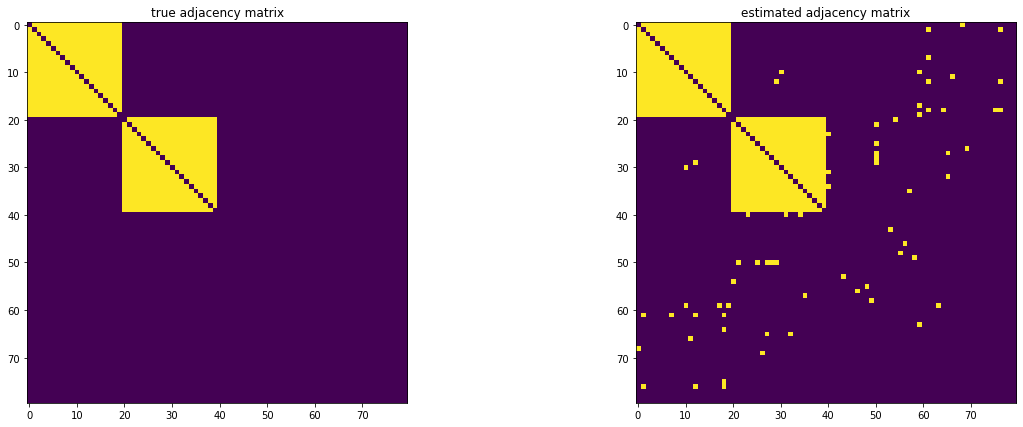

In [9]:
_, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].imshow(adjacency_matrix_true); ax[0].set_title('true adjacency matrix')
ax[1].imshow(adjacency_matrix); ax[1].set_title('estimated adjacency matrix')

We can see the hypothesis test correctly identifies the cluster whilst also having false positives.

### Calculate edge network representation needed for network analysis
This creates a dataframe with 3 columns, the gene names of all significant pairs and the cost of that interaction. The cost is defined in Equation (1) in the paper - the smaller, the stronger the interaction. 
This edge network can then be passed in to the network analysis code. The cost value may be interpreted as a weight in the graph and hence we pass in the reciprocal of the `cost_matrix`. The user could also pass in `qvalues` instead of the `cost_matrix` to obtain a weight based on value.

In [10]:
gene_names = [f'gene{i}' for i in range(G)]
edge_network = create_edge_network_representation(adjacency_matrix, 1/cost_matrix, gene_names)

Sparseness 0.131013


In [11]:
edge_network

,gene1,gene2,weight
0,gene0,gene1,0.066691
1,gene0,gene2,0.016120
2,gene0,gene3,0.091252
3,gene0,gene4,0.061772
4,gene0,gene5,0.012955
...,...,...,...
409,gene43,gene53,0.000195
410,gene46,gene56,0.000213
411,gene48,gene55,0.000203
412,gene49,gene58,0.000192
